In [8]:
import requests
from requests.exceptions import HTTPError

import pandas as pd
from decimal import Decimal
from pandas.io.json import json_normalize
import json

import numpy as np
import datetime as dt
from pandas_datareader import data as pdr



#Variables/Params
api_key = '46583da07984f6f5e5acc0442fad24656e164280da7811e9aefa8bcfc9d1' #defi pulse
request = '/defipulse/api/getLendingHistory' #getlending history
#add support for BulkAPIMonitor
requesturl = 'https://data-api.defipulse.com/api/v1' + request +'?api-key=' + api_key + '&period=1y'


In [2]:
#get json query
try:
    response = requests.get(requesturl)
    response.raise_for_status()
    # access JSOn content
    api_output = response.json()
    #print("Entire JSON response")
    #print(api_output[0]) #validate response from API

except HTTPError as http_err:
    print(f'HTTP error occurred: {http_err}')
except Exception as err:
    print(f'Other error occurred: {err}')


In [3]:
#extract lending data and dump into a dataframe
df = pd.DataFrame.from_dict(api_output)
df1 = df[['timestamp','lend_rates']]
timestamps = df1['timestamp']
timestamps = pd.to_datetime(timestamps,unit='s').dt.date
data = pd.json_normalize(df1['lend_rates'])
lendingdata = pd.merge(timestamps, data, left_index=True, right_index=True)

In [4]:
lendingdata['datetime'] = pd.to_datetime(lendingdata['timestamp'])
lendingdata = lendingdata.set_index(['datetime']).drop(columns=['timestamp']).divide(365)
lendingdata

,maker,compound,aave,dydx,c.r.e.a.m.-finance,definer
datetime,,,,,,
2021-08-26,0.000027,0.006533,0.006127,0.011176,0.012998,0.008424
2021-08-25,0.000027,0.006357,0.006434,0.009082,0.013389,0.008149
2021-08-24,0.000027,0.007266,0.005222,0.010912,0.017130,0.011809
2021-08-23,0.000027,0.006198,0.009735,0.009207,0.016258,0.008126
2021-08-22,0.000027,0.006127,0.009683,0.008773,0.015855,0.007937
...,...,...,...,...,...,...
2020-08-31,0.000000,0.007916,NaN,0.006663,0.015252,NaN
2020-08-30,0.000000,0.007892,NaN,0.006315,NaN,NaN
2020-08-29,0.000000,0.007927,NaN,0.005983,NaN,NaN


In [5]:
port_returns = []
port_volatility = []
port_weights = []

num_assets = len(lendingdata.columns)
num_portfolios = 30000

#compute asset return
individual_rets = lendingdata.resample('Y').last().mean().replace(np.inf, 0).replace(np.nan, 0)
var_matrix  = lendingdata #no need to divide as apy
var_matrix = var_matrix.cov()
var_matrix

for portfolio in range(num_portfolios):
    #generate random portfolio weights
    weights = np.random.random(num_assets)
    #normalise to 1
    weights = weights/np.sum(weights)
    port_weights.append(weights)
    #returs as dot product of expected asset ret and weight
    returns = np.dot(weights, individual_rets)
    port_returns.append(returns)

    #computer portfolio var
    var = var_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
    #daily standard deviation 
    sd = np.sqrt(var)
    #annualize std deviation to gove volatility (beta)
    ann_sd = sd*np.sqrt(250)
    port_volatility.append(ann_sd)


data = {'Returns':port_returns, 'Volatility':port_volatility}

for counter, symbol in enumerate(lendingdata.columns.tolist()):
    data[symbol+' weight'] = [w[counter] for w in port_weights]

portfolios_v1 = pd.DataFrame(data)
portfolios_v1.head()


,Returns,Volatility,maker weight,compound weight,aave weight,dydx weight,c.r.e.a.m.-finance weight,definer weight
0,0.010831,0.106860,0.152077,0.130307,0.217209,0.084118,0.210016,0.206273
1,0.011377,0.133752,0.113947,0.064131,0.257668,0.229436,0.216113,0.118704
2,0.010292,0.091630,0.239864,0.233913,0.142576,0.044946,0.181240,0.157462
3,0.009673,0.103636,0.196023,0.273002,0.327035,0.054148,0.128093,0.021699
4,0.012392,0.153309,0.001064,0.130464,0.330934,0.308812,0.168022,0.060704


maker                 0.000014
compound              0.015030
aave                  0.006127
dydx                  0.014282
c.r.e.a.m.-finance    0.020031
definer               0.010334
dtype: float64

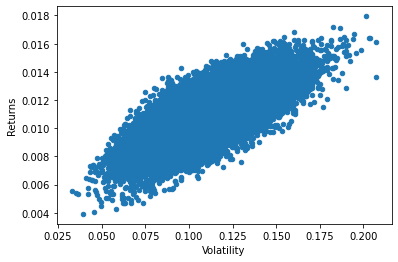

In [6]:
#plot efficient frontier
plt = portfolios_v1.plot.scatter(x='Volatility', y='Returns', marker='o')

individual_rets

In [7]:
rf = 0.01 #risk factor
optimal_risky_port = portfolios_v1.iloc[((portfolios_v1['Returns']-rf)/portfolios_v1['Volatility']).idxmax()]
optimal_risky_port


Returns                      0.015965
Volatility                   0.130728
maker weight                 0.013957
compound weight              0.581104
aave weight                  0.004990
dydx weight                  0.048884
c.r.e.a.m.-finance weight    0.296371
definer weight               0.054694
Name: 1585, dtype: float64